# ME455 - HW3
Zhengyang Kris Weng - Spring 2025

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Image loading packages
from PIL import Image
from io import BytesIO


1. Given the image here, convert it into a continuous probability density function over
a space of 1 meter by 1 meter (you can find the example code for how to do it here). Imple-
ment rejection sampling to sample 5000 points from this image-based probability distribution.
Select two di↵erent proposal distributions of your choice for your implementation.

image_array.shape:  (250, 250)


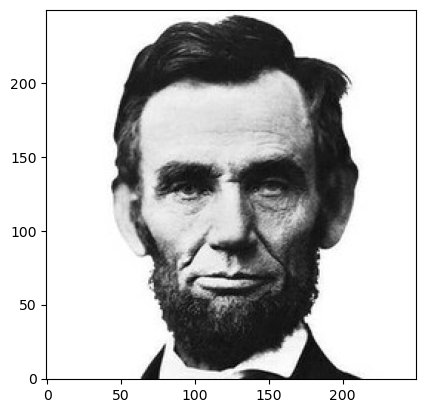

In [3]:
# Load the image
image_path = 'lincoln.jpg'  # Replace with the actual path to your image
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert the image to a NumPy array
image_array = np.array(image)
image_array = np.flip(image_array, axis=0)

print('image_array.shape: ', image_array.shape)

plt.imshow(image_array, origin='lower', cmap='gray') # note that for "imshow" the origin of the coordinate is at top left instead of bottom left
plt.show()
plt.close()

In [4]:
xgrids = np.linspace(0.0, 1.0, image_array.shape[0])  # the x coordinates of image pixels in the new space
dx = xgrids[1] - xgrids[0]
ygrids = np.linspace(0.0, 1.0, image_array.shape[1])  # the y coordinates of image pixels in the new space
dy = ygrids[1] - ygrids[0]

# we now invert dark and light pixel density and normalize the density values so it is a valid probability distribution
density_array = 255.0 - image_array  # we want higher density at darker regions
density_array /= np.sum(density_array) * dx * dy  # so the integral is 1

def image_density(s):
    """ Continuous density function based on the image
    Inputs:
        s - a numpy array containing the (x,y) coordinate within the 1m-by-1m space
    Return:
        val - the density value at s
    """
    s_x, s_y = s

    # Find the pixel closest to s in the 1-by-1 space
    # Note that in image the first pixel coordinate correspond to the y-axis in the 1-by-1 space
    pixel_idx_y = np.argmin(np.abs(xgrids - s_x))
    pixel_idx_x = np.argmin(np.abs(ygrids - s_y))

    # the density at s is the same as the closest pixel density
    val = density_array[pixel_idx_x, pixel_idx_y]

    return val

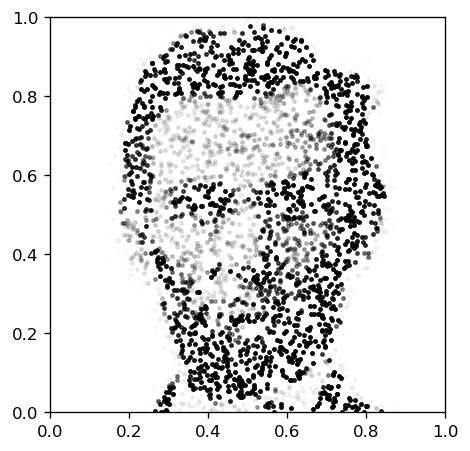

In [5]:
num_samples = 5000
samples = np.random.uniform(low=0.0, high=1.0, size=(num_samples,2))
sample_weights = np.zeros(num_samples)

for i in range(num_samples):
    sample_weights[i] = image_density(samples[i])

# for visualization purpose, we adjust the weights such that the maximum weight is 1.0
# (matplotlib only accepts values between 0.0 to 1.0 as the opacity value)
# (this is not the same as normalization in importance sampling or rejection sampling)
sample_weights /= np.max(sample_weights)

# now we visualize the weighted samples
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=120, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

for sample, weight in zip(samples, sample_weights):
    ax.plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k', alpha=weight)

plt.show()
plt.close()

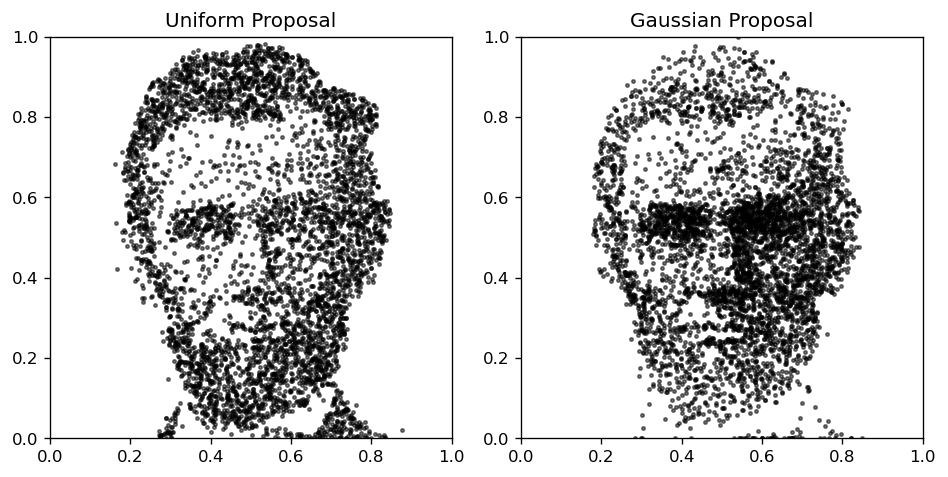

In [7]:
# Define two proposal distributions
def uniform_proposal(size):
    """Uniform proposal distribution over the 1m x 1m space."""
    return np.random.uniform(low=0.0, high=1.0, size=size)

def gaussian_proposal(size):
    """Gaussian proposal distribution centered at (0.5, 0.5) with std deviation 0.2."""
    samples = np.random.normal(loc=0.5, scale=0.2, size=size)
    return np.clip(samples, 0.0, 1.0)  # Ensure samples are within the 1m x 1m space

# Perform rejection sampling for both proposal distributions
def rejection_sampling(proposal_func, num_samples):
    samples = []
    while len(samples) < num_samples:
        proposed_sample = proposal_func(size=(2,))
        density_at_sample = image_density(proposed_sample)
        random_value = np.random.uniform(low=0.0, high=density_max)
        if random_value < density_at_sample:
            samples.append(proposed_sample)
    return np.array(samples)

# Generate samples using both proposal distributions
num_rejection_samples = 5000
uniform_samples = rejection_sampling(uniform_proposal, num_rejection_samples)
gaussian_samples = rejection_sampling(gaussian_proposal, num_rejection_samples)

# Visualize the results side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=120, tight_layout=True)
axes[0].set_title("Uniform Proposal")
axes[0].set_aspect('equal')
axes[0].set_xlim(0.0, 1.0)
axes[0].set_ylim(0.0, 1.0)
axes[0].plot(uniform_samples[:, 0], uniform_samples[:, 1], linestyle='', marker='o', markersize=2, color='k', alpha=0.5)

axes[1].set_title("Gaussian Proposal")
axes[1].set_aspect('equal')
axes[1].set_xlim(0.0, 1.0)
axes[1].set_ylim(0.0, 1.0)
axes[1].plot(gaussian_samples[:, 0], gaussian_samples[:, 1], linestyle='', marker='o', markersize=2, color='k', alpha=0.5)

plt.show()
plt.close()

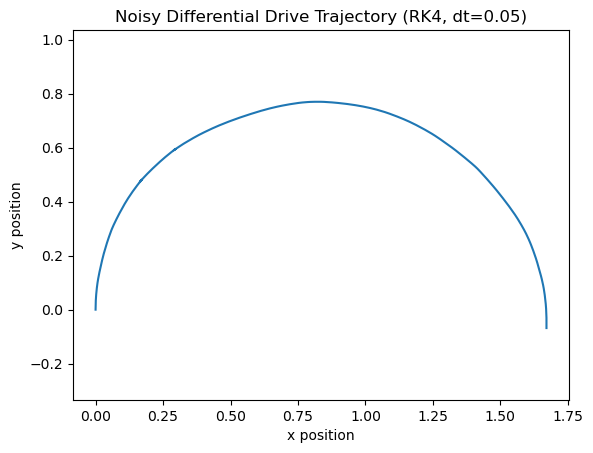

In [32]:
def f(state, u):
    """
    Continuous-time dynamics of the differential drive robot.
    state: [x, y, theta]
    u: [u1, u2]
    """
    x, y, theta = state
    u1, u2 = u
    dx = np.cos(theta) * u1
    dy = np.sin(theta) * u1
    dtheta = u2
    return np.array([dx, dy, dtheta])

# Simulation parameters
dt = 0.05                     # time step
T = 5                      # total simulation time
N = int(T / dt)               # number of steps

# Nominal control inputs (constant for example)
u_nominal = np.array([0.5, -0.63])  

# Noise covariance on [u1, u2]
cov = np.diag([0.04, 0.02])

# Preallocate arrays
states = np.zeros((N+1, 3))
times = np.linspace(0, T, N+1)

# Initial condition
states[0] = np.array([0.0, 0.0, np.pi/2])

# RK4 integration with noisy controls
for i in range(N):
    state = states[i]
    noise = np.random.multivariate_normal(np.zeros(2), cov)
    u_noisy = u_nominal + noise

    k1 = f(state, u_noisy)
    k2 = f(state + 0.5 * dt * k1, u_noisy)
    k3 = f(state + 0.5 * dt * k2, u_noisy)
    k4 = f(state + dt * k3, u_noisy)

    states[i+1] = state + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Plot the noisy ground-truth trajectory
plt.figure()
plt.plot(states[:,0], states[:,1])
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Noisy Differential Drive Trajectory (RK4, dt=0.05)')
plt.axis('equal')
plt.show()


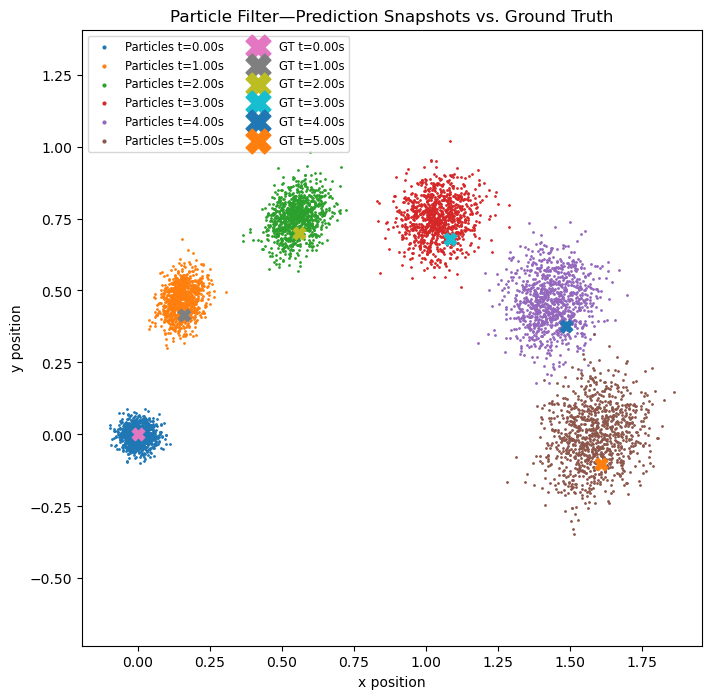

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define the continuous-time dynamics in a vectorized form
def f(states, us):
    """
    states: (M,3) array of [x, y, theta]
    us:     (M,2) array of [u1, u2]
    returns: (M,3) array of [dx, dy, dtheta]
    """
    thetas = states[:, 2]
    u1 = us[:, 0]
    u2 = us[:, 1]
    dx = np.cos(thetas) * u1
    dy = np.sin(thetas) * u1
    dtheta = u2
    return np.stack([dx, dy, dtheta], axis=1)

# 2) Simulation parameters
dt = 0.05
N = 100                        # 100 steps of 0.05s => 5 seconds
u_nominal = np.array([0.5, -0.63])
process_cov = np.diag([0.04, 0.02])

# 3) Simulate ground truth
gt_states = np.zeros((N+1, 3))
gt_states[0] = [0.0, 0.0, np.pi/2]
for i in range(N):
    noise = np.random.multivariate_normal(np.zeros(2), process_cov)
    u_noisy = u_nominal + noise
    # RK4 for single state
    k1 = f(gt_states[i:i+1], np.array([u_noisy]))[0]
    k2 = f(gt_states[i:i+1] + 0.5*dt*k1, np.array([u_noisy]))[0]
    k3 = f(gt_states[i:i+1] + 0.5*dt*k2, np.array([u_noisy]))[0]
    k4 = f(gt_states[i:i+1] +      dt*k3, np.array([u_noisy]))[0]
    gt_states[i+1] = gt_states[i] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

# 4) Initialize particles
M = 1000
init_cov = np.diag([1e-3, 1e-3, 1e-4])
particles = np.random.multivariate_normal(gt_states[0], init_cov, size=M)

# Time steps at which to take snapshots
snapshot_steps = [0, 20, 40, 60, 80, 100]
snapshots = {0: particles.copy()}

# 5) Propagate all particles forward (prediction only)
for i in range(N):
    noise = np.random.multivariate_normal(np.zeros(2), process_cov, size=M)
    u_noisy = u_nominal + noise
    k1 = f(particles,                  u_noisy)
    k2 = f(particles + 0.5*dt*k1,      u_noisy)
    k3 = f(particles + 0.5*dt*k2,      u_noisy)
    k4 = f(particles +     dt*k3,      u_noisy)
    particles += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    if (i+1) in snapshot_steps:
        snapshots[i+1] = particles.copy()

# 6) Plot everything
plt.figure(figsize=(8,8))

# Plot particle clouds at each snapshot
for t, ps in snapshots.items():
    plt.scatter(ps[:,0], ps[:,1], s=1, label=f'Particles t={t*dt:.2f}s')

# Plot ground-truth positions at the same times
for t in snapshot_steps:
    x_gt, y_gt, _ = gt_states[t]
    plt.scatter(x_gt, y_gt, marker='X', s=80, label=f'GT t={t*dt:.2f}s')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Particle Filter—Prediction Snapshots vs. Ground Truth')
plt.axis('equal')
plt.legend(fontsize='small', markerscale=2, ncol=2)
plt.show()


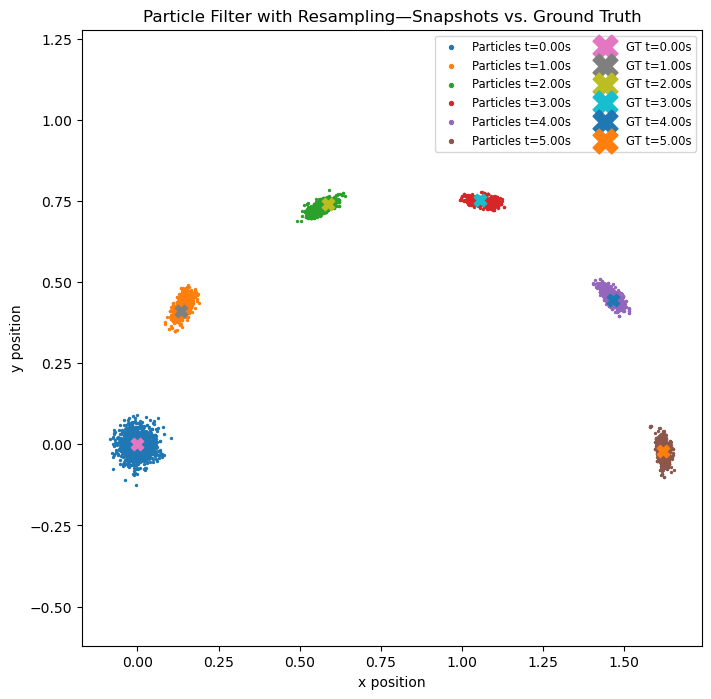

In [29]:
meas_cov_diag = np.array([0.004, 0.004, 0.002])

# 4) Initialize particles again
particles = np.random.multivariate_normal(gt_states[0], init_cov, size=M)

# 5) Time steps at which to take snapshots
snapshot_steps = [0, 20, 40, 60, 80, 100]
snapshots = {0: particles.copy()}

# 6) Particle filter with resampling (prediction + measurement update)
for i in range(N):
    # Prediction
    noise = np.random.multivariate_normal(np.zeros(2), process_cov, size=M)
    u_noisy = u_nominal + noise
    k1 = f(particles, u_noisy)
    k2 = f(particles + 0.5*dt*k1, u_noisy)
    k3 = f(particles + 0.5*dt*k2, u_noisy)
    k4 = f(particles + dt*k3, u_noisy)
    particles = particles + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    # Measurement update & resample
    z = gt_states[i+1]
    diffs = particles - z
    exponent = -0.5 * np.sum((diffs**2) / meas_cov_diag, axis=1)
    weights = np.exp(exponent)
    weights /= np.sum(weights)
    
    # Resample using numpy.random.choice
    idx = np.random.choice(M, size=M, replace=True, p=weights)
    particles = particles[idx]
    
    # Snapshot
    if (i+1) in snapshot_steps:
        snapshots[i+1] = particles.copy()

# 7) Plot results
plt.figure(figsize=(8, 8))
for step, ps in snapshots.items():
    t = step * dt
    plt.scatter(ps[:, 0], ps[:, 1], s=2, label=f'Particles t={t:.2f}s')
for step in snapshot_steps:
    x, y, _ = gt_states[step]
    plt.scatter(x, y, marker='X', s=80, label=f'GT t={step*dt:.2f}s')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Particle Filter with Resampling—Snapshots vs. Ground Truth')
plt.axis('equal')
plt.legend(fontsize='small', markerscale=2, ncol=2)
plt.show()
